# Deep Learning to find Well Pads

In [5]:
from arcgis.gis import GIS
from arcgis.raster.functions import apply 
from arcgis.learn import export_training_data

gis = GIS("home")
arcgis_online = GIS("https://www.arcgis.com", "arcgis_python", "P@ssword123", set_active=False)

<Item title:"Well Pads" type:Feature Layer Collection owner:portaladmin>
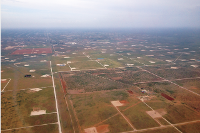

In [2]:
well_pads = gis.content.get('ae6f1c62027c42b8a88c4cf5deb86bbf') # Well pads layer
well_pads

<Item title:"Sentinel-2 Imagery: Natural Color with DRA" type:Imagery Layer owner:esri>
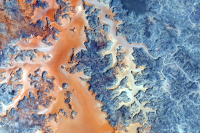

In [3]:
sentinel_item = arcgis_online.content.get("41c1069f84eb40ff90940c0299f31c77") # Sentinel-2 layer
sentinel_item

# Export Training Samples

In [4]:
sentinel_data = apply(sentinel_item.layers[0], 'Natural Color with DRA', astype='U8')

In [ ]:
chips = export_training_data(sentinel_data, well_pads, "PNG", {"x":448,"y":448}, {"x":224,"y":224}, "PASCAL_VOC_rectangles", 75, "well_pads")

# Prepare Data

In [32]:
from arcgis.learn import prepare_data

data = prepare_data('/arcgis/directories/rasterstore/well_pads', {0: '   Pad'})

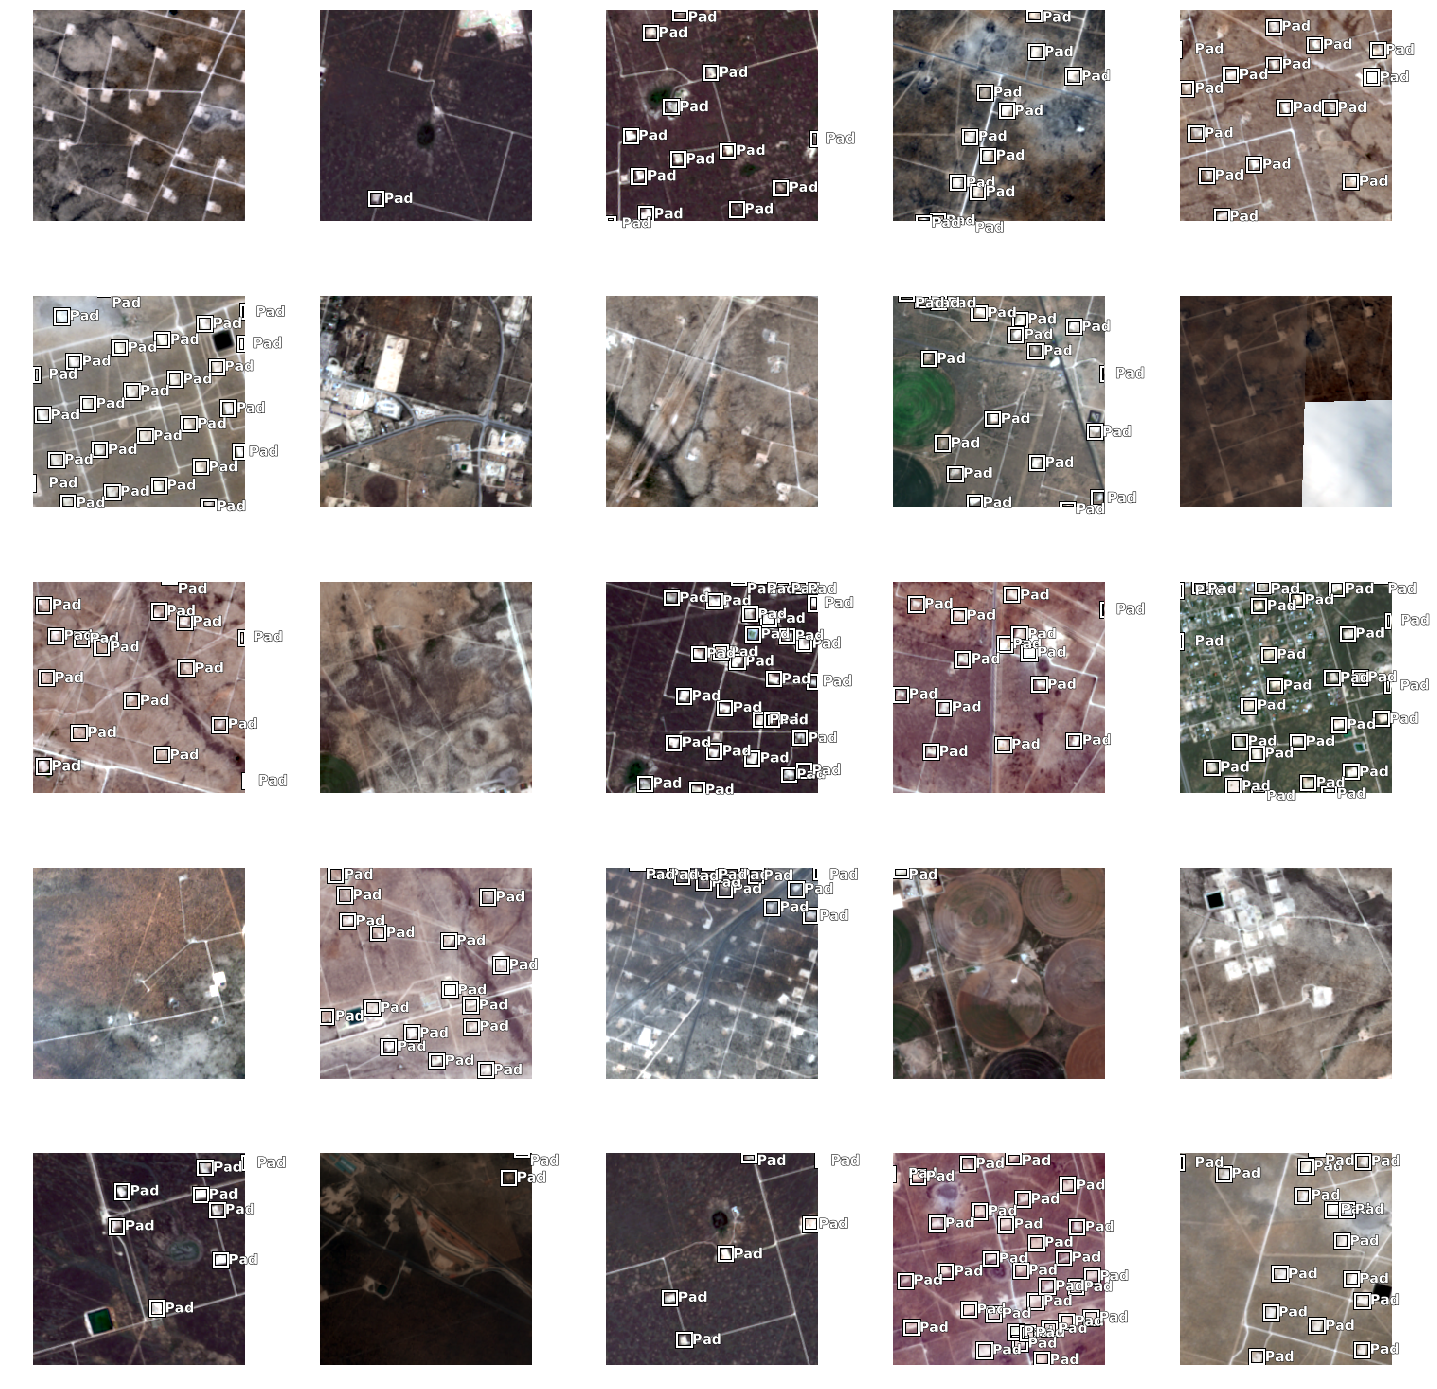

In [15]:
data.show_batch()

### Train SingleShotDetector Model

In [33]:
from arcgis.learn import SingleShotDetector

ssd = SingleShotDetector(data, grids=[9], zooms=[1.0], ratios=[[1.0, 1.0]])

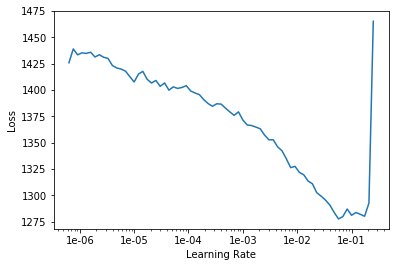

In [9]:
ssd.lr_find()

In [10]:
ssd.fit(10, slice(0.001, 0.02))

/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


CPU times: user 2.29 s, sys: 496 ms, total: 2.79 s
Wall time: 3.02 s


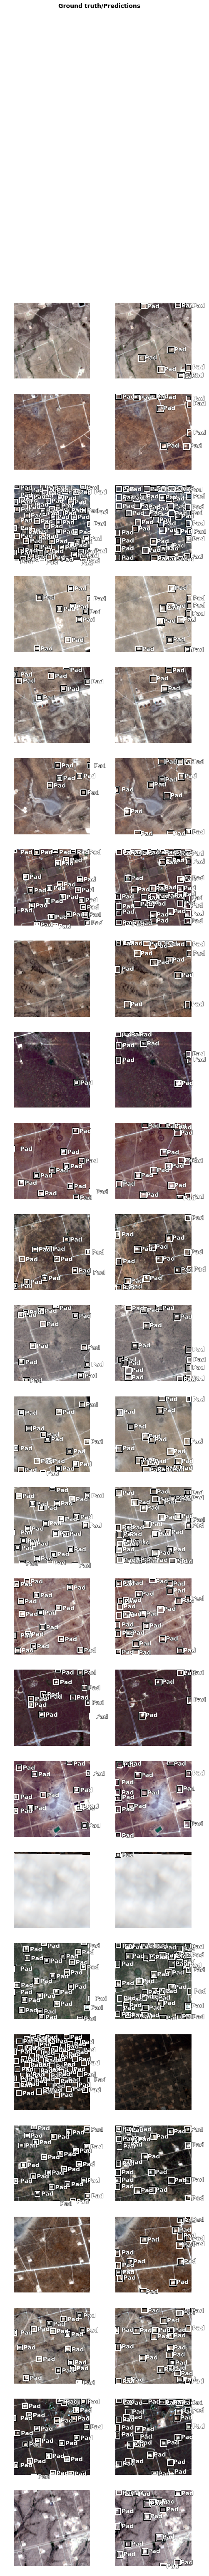

In [37]:
ssd.show_results(rows=25, thresh=0.05)

In [41]:
ssd.save('WellPadDetector')

Created model files at /arcgis/directories/rasterstore/well_pads/models/WellPadDetector


# Deploy model to find well pads

In [25]:
trained_model = '/arcgis/directories/rasterstore/well_pads/models/WellPadDetector/WellPadDetector.zip'

In [26]:
model_package = gis.content.add(item_properties={"type":"Deep Learning Package","typeKeywords":"Deep Learning, Raster",
                                                 "title":"Well Pad Detection Model",
                                                 "tags":"deeplearning", 'overwrite':'True'}, data=trained_model)

In [27]:
model_package

<Item title:"Well Pad Detection Model" type:Deep Learning Package owner:portaladmin>

In [6]:
from arcgis.learn import Model

detect_objects_model = Model(model_package)

In [7]:
context = {'cellSize': 10,
           'processorType':'GPU',
           'extent':{'xmin': -11587791.393960,
                     'ymin': 3767970.198031,
                     'xmax': -11454320.817016,
                     'ymax': 3875304.476397, 'spatialReference': {'latestWkid': 3857, 'wkid': 102100}}}

In [8]:
params = {'padding':'0', 'threshold':'0.05', 'nms_overlap':'0.1', 'batch_size':'64'}

In [10]:
from arcgis.learn import detect_objects

detected_pads = detect_objects(input_raster=sentinel_data,
                              model=detect_objects_model,
                              model_arguments=params,
                              output_name="Well_Pads_Detect_full3",
                              context=context,
                              gis=gis)

In [11]:
detected_pads

<Item title:"Well_Pads_Detect_full3" type:Feature Layer Collection owner:portaladmin>